# Robustness Simulations

This script requires following datasets for it to run:

- 'DataFrame'
- 'clean_data'
- 'TEST_DF'
- 'adjacency_matrix.csv'
- 'adjacency_matrix_test_graph.csv'

In [1]:
# %% Load the required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sage import SAGEConv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

## Load the Data and Pre-Process

In [3]:
# %% data loading and pre-processing

df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
features = pd.Series(X.satisfaction) 
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

TEST = pd.read_csv('TEST_DF')
test_features = pd.Series(TEST.satisfaction)
test_vars = TEST.drop(columns=['Unnamed: 0','satisfaction'])
test_vars.Class = test_vars.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
test_wd = pd.get_dummies(data=test_vars,columns=['Customer Type','Type of Travel','Gender'])
test_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(test_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load Training- Validation Graph and Test Graph

In [4]:
# %%  load graph data

A = np.loadtxt('adjacency_matrix.csv', delimiter=',')
G = nx.from_numpy_matrix(A)
A_test = np.loadtxt('adjacency_matrix_test_graph.csv', delimiter=',')
G_test = nx.from_numpy_matrix(A_test)

## Define the GraphSage Model

In [6]:
# %% Normalization function

def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [7]:
# %% GraphSage Class

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, agg_type):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [8]:
# %% SumSage Class for sum-pooling

class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

## Define the Inference Function

In [9]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in dataloader:
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

## Define the Simulation Function

In [10]:
## %% Simulation function

def Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'pool',sum_sage=False):

    train_acc_exp = []
    val_acc_exp = []
    exp_losses_train = []
    exp_losses_val = []
    test_acc = []
    plot_loss_test = []
    

    G_dgl_test = dgl.from_networkx(G_test)
    feat_test = TEST.drop(columns=['satisfaction'])
    feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
    feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

    G_dgl_test.ndata['feat'] =  torch.tensor(test_wd.values,dtype=torch.float)
    G_dgl_test.ndata['label'] = torch.tensor(test_features)
    
    node_features_test = G_dgl_test.ndata['feat']
    node_labels_test = G_dgl_test.ndata['label']
    test_nids = G_dgl_test.nodes()
    n_features_test = node_features_test.shape[1]
    n_labels_test = int(node_labels_test.max().item() + 1)
    
    G_dgl = dgl.from_networkx(G)
    G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
    G_dgl.ndata['label'] = torch.tensor(features)
    
    for n in range(nExp):
        print('Experiment: {}'.format(n))
        
        G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)

        G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
        for i in range(len(G_dgl.ndata['train_mask'])):
            if G_dgl.ndata['train_mask'][i] == True:
                G_dgl.ndata['val_mask'][i] = False
            else:
                G_dgl.ndata['val_mask'][i] = True

        G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

        node_features = G_dgl.ndata['feat']
        node_labels = G_dgl.ndata['label']
        train_mask = G_dgl.ndata['train_mask']
        valid_mask = G_dgl.ndata['val_mask']
        n_features = node_features.shape[1]
        n_labels = int(node_labels.max().item() + 1)

        train_nodes = (train_mask == True).nonzero(as_tuple=False)
        train_nids = torch.reshape(train_nodes,(-1,))
        valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
        valid_nids = torch.reshape(valid_nodes,(-1,))

        batch_size = 50
        sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
        train_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, train_nids, sampler,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=0
        )

        batch_size = len(valid_nids)
        valid_dataloader = dgl.dataloading.NodeDataLoader(
            G_dgl, valid_nids, sampler,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=0
        )

        if sum_sage is True:
            model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
        else:
            model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type) #n_layers
        opt = torch.optim.Adam(model.parameters(), lr=0.002)


        best_accuracy = 0
        epoch_losses_train = []
        plot_loss_valid = []
        train_acc = []
        valid_acc = []
        dur = []

        for epoch in range(400):
            t0 = time.time()
            model.train()
            loss_epoch = 0
            accuracy_epoch = 0
            for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
                inputs = node_features[input_nodes]
                labels = node_labels[output_nodes]
                logits = model(bipartites, inputs)
                predictions = F.log_softmax(logits,dim=1)

                loss = F.cross_entropy(logits, labels)
                loss_epoch += loss.detach().item()
                opt.zero_grad()
                loss.backward()
                opt.step()

                accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
                accuracy_epoch += accuracy
            accuracy_epoch /= (step + 1)
            loss_epoch /= (step + 1)
            epoch_losses_train.append(loss_epoch)
            train_acc.append(accuracy_epoch)
            print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
            model.eval()
    
            predictions = []
            labels = []
            with torch.no_grad():
                for input_nodes, output_nodes, bipartites in valid_dataloader:
                    inputs = node_features[input_nodes]
                    labels.append(node_labels[output_nodes].numpy())
                    predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
                    valid_logits = model(bipartites, inputs)
                    valid_labels = node_labels[output_nodes]
                    valid_loss = F.cross_entropy(valid_logits, valid_labels)

                predictions = np.concatenate(predictions)
                labels = np.concatenate(labels)
        
                accuracy = accuracy_score(labels, predictions)
                dur.append(time.time() - t0)
                print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
                valid_acc.append(accuracy.item())
                plot_loss_valid.append(valid_loss.item())

        train_acc_exp.append(train_acc[-1])
        val_acc_exp.append(valid_acc[-1])
        exp_losses_train.append(epoch_losses_train[-1])
        exp_losses_val.append(plot_loss_valid[-1])

        
        all_logits = inference(model, G_dgl_test, node_features_test, len(test_nids))
        test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
        test_labels = node_labels_test[test_nids]
        test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
        test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
        print('Test accuracy: {:.3f}, Test Loss: {:.3f}'.format(test_accuracy,test_loss))
    
        test_acc.append(test_accuracy.item())
        plot_loss_test.append(test_loss.item())
        

    return (train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_acc, plot_loss_test)


## Run the Experiments

For the simulation, define the number of experiments, the aggregation type and indicate whether SumSage or standard GraphSage should be run.

In [11]:
# %% Run Experiments mean

nExp = 10
train_acc_exp, val_acc_exp, exp_losses_train, exp_losses_val, test_accuracy_exp, test_loss_exp = Simulation(nExp,G,x_wd,features,G_test,test_wd,test_features,agg_type = 'mean',sum_sage=False)

Experiment: 0
Epoch: 0, Training Accuracy: 0.695, Training Loss: 0.602
Epoch: 0, Validation Accuracy: 0.823, Validation Loss: 0.478, Time: 1.0594
Epoch: 1, Training Accuracy: 0.821, Training Loss: 0.453
Epoch: 1, Validation Accuracy: 0.850, Validation Loss: 0.386, Time: 0.9845
Epoch: 2, Training Accuracy: 0.844, Training Loss: 0.399
Epoch: 2, Validation Accuracy: 0.859, Validation Loss: 0.362, Time: 0.9958
Epoch: 3, Training Accuracy: 0.848, Training Loss: 0.379
Epoch: 3, Validation Accuracy: 0.872, Validation Loss: 0.332, Time: 0.9969
Epoch: 4, Training Accuracy: 0.856, Training Loss: 0.364
Epoch: 4, Validation Accuracy: 0.868, Validation Loss: 0.336, Time: 0.9979
Epoch: 5, Training Accuracy: 0.859, Training Loss: 0.356
Epoch: 5, Validation Accuracy: 0.878, Validation Loss: 0.314, Time: 1.0414
Epoch: 6, Training Accuracy: 0.864, Training Loss: 0.345
Epoch: 6, Validation Accuracy: 0.878, Validation Loss: 0.310, Time: 1.0494
Epoch: 7, Training Accuracy: 0.865, Training Loss: 0.343
Epoch

Epoch: 62, Training Accuracy: 0.930, Training Loss: 0.173
Epoch: 62, Validation Accuracy: 0.948, Validation Loss: 0.146, Time: 1.0299
Epoch: 63, Training Accuracy: 0.934, Training Loss: 0.172
Epoch: 63, Validation Accuracy: 0.947, Validation Loss: 0.145, Time: 1.0301
Epoch: 64, Training Accuracy: 0.932, Training Loss: 0.176
Epoch: 64, Validation Accuracy: 0.946, Validation Loss: 0.146, Time: 1.0301
Epoch: 65, Training Accuracy: 0.928, Training Loss: 0.177
Epoch: 65, Validation Accuracy: 0.927, Validation Loss: 0.184, Time: 1.0315
Epoch: 66, Training Accuracy: 0.930, Training Loss: 0.175
Epoch: 66, Validation Accuracy: 0.936, Validation Loss: 0.165, Time: 1.0315
Epoch: 67, Training Accuracy: 0.931, Training Loss: 0.182
Epoch: 67, Validation Accuracy: 0.948, Validation Loss: 0.144, Time: 1.0322
Epoch: 68, Training Accuracy: 0.935, Training Loss: 0.174
Epoch: 68, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.0322
Epoch: 69, Training Accuracy: 0.926, Training Loss: 0.180
Epoc

Epoch: 123, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 123, Validation Accuracy: 0.953, Validation Loss: 0.133, Time: 1.0664
Epoch: 124, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 124, Validation Accuracy: 0.944, Validation Loss: 0.133, Time: 1.0676
Epoch: 125, Training Accuracy: 0.939, Training Loss: 0.152
Epoch: 125, Validation Accuracy: 0.954, Validation Loss: 0.119, Time: 1.0686
Epoch: 126, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 126, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.0694
Epoch: 127, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 127, Validation Accuracy: 0.957, Validation Loss: 0.121, Time: 1.0693
Epoch: 128, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 128, Validation Accuracy: 0.951, Validation Loss: 0.121, Time: 1.0695
Epoch: 129, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 129, Validation Accuracy: 0.956, Validation Loss: 0.115, Time: 1.0714
Epoch: 130, Training Accuracy: 0.941, Training L

Epoch: 184, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 184, Validation Accuracy: 0.960, Validation Loss: 0.108, Time: 1.0865
Epoch: 185, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 185, Validation Accuracy: 0.962, Validation Loss: 0.102, Time: 1.0870
Epoch: 186, Training Accuracy: 0.944, Training Loss: 0.146
Epoch: 186, Validation Accuracy: 0.950, Validation Loss: 0.118, Time: 1.0885
Epoch: 187, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 187, Validation Accuracy: 0.959, Validation Loss: 0.116, Time: 1.0895
Epoch: 188, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 188, Validation Accuracy: 0.952, Validation Loss: 0.121, Time: 1.0906
Epoch: 189, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 189, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.0907
Epoch: 190, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 190, Validation Accuracy: 0.951, Validation Loss: 0.141, Time: 1.0914
Epoch: 191, Training Accuracy: 0.940, Training L

Epoch: 245, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 245, Validation Accuracy: 0.959, Validation Loss: 0.117, Time: 1.1083
Epoch: 246, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 246, Validation Accuracy: 0.957, Validation Loss: 0.106, Time: 1.1083
Epoch: 247, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 247, Validation Accuracy: 0.957, Validation Loss: 0.109, Time: 1.1084
Epoch: 248, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 248, Validation Accuracy: 0.965, Validation Loss: 0.109, Time: 1.1090
Epoch: 249, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 249, Validation Accuracy: 0.959, Validation Loss: 0.109, Time: 1.1097
Epoch: 250, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 250, Validation Accuracy: 0.959, Validation Loss: 0.109, Time: 1.1105
Epoch: 251, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 251, Validation Accuracy: 0.959, Validation Loss: 0.109, Time: 1.1103
Epoch: 252, Training Accuracy: 0.944, Training L

Epoch: 306, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 306, Validation Accuracy: 0.954, Validation Loss: 0.122, Time: 1.1055
Epoch: 307, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 307, Validation Accuracy: 0.963, Validation Loss: 0.098, Time: 1.1058
Epoch: 308, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 308, Validation Accuracy: 0.959, Validation Loss: 0.117, Time: 1.1057
Epoch: 309, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 309, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.1063
Epoch: 310, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 310, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1062
Epoch: 311, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 311, Validation Accuracy: 0.945, Validation Loss: 0.163, Time: 1.1059
Epoch: 312, Training Accuracy: 0.940, Training Loss: 0.148
Epoch: 312, Validation Accuracy: 0.959, Validation Loss: 0.112, Time: 1.1056
Epoch: 313, Training Accuracy: 0.951, Training L

Epoch: 367, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 367, Validation Accuracy: 0.963, Validation Loss: 0.107, Time: 1.1071
Epoch: 368, Training Accuracy: 0.943, Training Loss: 0.137
Epoch: 368, Validation Accuracy: 0.962, Validation Loss: 0.106, Time: 1.1069
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 369, Validation Accuracy: 0.954, Validation Loss: 0.112, Time: 1.1067
Epoch: 370, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 370, Validation Accuracy: 0.962, Validation Loss: 0.104, Time: 1.1066
Epoch: 371, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 371, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 1.1063
Epoch: 372, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 372, Validation Accuracy: 0.957, Validation Loss: 0.117, Time: 1.1066
Epoch: 373, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 373, Validation Accuracy: 0.966, Validation Loss: 0.101, Time: 1.1070
Epoch: 374, Training Accuracy: 0.951, Training L

Epoch: 28, Training Accuracy: 0.908, Training Loss: 0.224
Epoch: 28, Validation Accuracy: 0.913, Validation Loss: 0.214, Time: 1.9070
Epoch: 29, Training Accuracy: 0.918, Training Loss: 0.210
Epoch: 29, Validation Accuracy: 0.912, Validation Loss: 0.209, Time: 1.8831
Epoch: 30, Training Accuracy: 0.913, Training Loss: 0.216
Epoch: 30, Validation Accuracy: 0.910, Validation Loss: 0.210, Time: 1.8666
Epoch: 31, Training Accuracy: 0.915, Training Loss: 0.213
Epoch: 31, Validation Accuracy: 0.909, Validation Loss: 0.209, Time: 1.8548
Epoch: 32, Training Accuracy: 0.914, Training Loss: 0.212
Epoch: 32, Validation Accuracy: 0.922, Validation Loss: 0.206, Time: 1.8416
Epoch: 33, Training Accuracy: 0.914, Training Loss: 0.217
Epoch: 33, Validation Accuracy: 0.906, Validation Loss: 0.214, Time: 1.8192
Epoch: 34, Training Accuracy: 0.919, Training Loss: 0.197
Epoch: 34, Validation Accuracy: 0.915, Validation Loss: 0.207, Time: 1.8012
Epoch: 35, Training Accuracy: 0.921, Training Loss: 0.202
Epoc

Epoch: 90, Training Accuracy: 0.944, Training Loss: 0.154
Epoch: 90, Validation Accuracy: 0.937, Validation Loss: 0.147, Time: 1.4550
Epoch: 91, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 91, Validation Accuracy: 0.939, Validation Loss: 0.143, Time: 1.4514
Epoch: 92, Training Accuracy: 0.943, Training Loss: 0.156
Epoch: 92, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.4474
Epoch: 93, Training Accuracy: 0.939, Training Loss: 0.159
Epoch: 93, Validation Accuracy: 0.941, Validation Loss: 0.146, Time: 1.4431
Epoch: 94, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 94, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.4380
Epoch: 95, Training Accuracy: 0.943, Training Loss: 0.152
Epoch: 95, Validation Accuracy: 0.942, Validation Loss: 0.149, Time: 1.4322
Epoch: 96, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 96, Validation Accuracy: 0.932, Validation Loss: 0.157, Time: 1.4268
Epoch: 97, Training Accuracy: 0.935, Training Loss: 0.159
Epoc

Epoch: 151, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 151, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.2621
Epoch: 152, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 152, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.2631
Epoch: 153, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 153, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.2625
Epoch: 154, Training Accuracy: 0.950, Training Loss: 0.140
Epoch: 154, Validation Accuracy: 0.940, Validation Loss: 0.131, Time: 1.2621
Epoch: 155, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 155, Validation Accuracy: 0.943, Validation Loss: 0.131, Time: 1.2604
Epoch: 156, Training Accuracy: 0.945, Training Loss: 0.141
Epoch: 156, Validation Accuracy: 0.939, Validation Loss: 0.134, Time: 1.2580
Epoch: 157, Training Accuracy: 0.939, Training Loss: 0.151
Epoch: 157, Validation Accuracy: 0.938, Validation Loss: 0.139, Time: 1.2558
Epoch: 158, Training Accuracy: 0.942, Training L

Epoch: 212, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 212, Validation Accuracy: 0.943, Validation Loss: 0.135, Time: 1.2166
Epoch: 213, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 213, Validation Accuracy: 0.942, Validation Loss: 0.130, Time: 1.2157
Epoch: 214, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 214, Validation Accuracy: 0.947, Validation Loss: 0.123, Time: 1.2147
Epoch: 215, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 215, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.2138
Epoch: 216, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 216, Validation Accuracy: 0.942, Validation Loss: 0.129, Time: 1.2131
Epoch: 217, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 217, Validation Accuracy: 0.946, Validation Loss: 0.126, Time: 1.2121
Epoch: 218, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 218, Validation Accuracy: 0.945, Validation Loss: 0.128, Time: 1.2113
Epoch: 219, Training Accuracy: 0.946, Training L

Epoch: 273, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 273, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.1794
Epoch: 274, Training Accuracy: 0.949, Training Loss: 0.137
Epoch: 274, Validation Accuracy: 0.951, Validation Loss: 0.132, Time: 1.1795
Epoch: 275, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 275, Validation Accuracy: 0.952, Validation Loss: 0.114, Time: 1.1799
Epoch: 276, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 276, Validation Accuracy: 0.934, Validation Loss: 0.173, Time: 1.1795
Epoch: 277, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 277, Validation Accuracy: 0.945, Validation Loss: 0.129, Time: 1.1792
Epoch: 278, Training Accuracy: 0.953, Training Loss: 0.131
Epoch: 278, Validation Accuracy: 0.947, Validation Loss: 0.125, Time: 1.1786
Epoch: 279, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 279, Validation Accuracy: 0.943, Validation Loss: 0.130, Time: 1.1783
Epoch: 280, Training Accuracy: 0.948, Training L

Epoch: 334, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 334, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.1676
Epoch: 335, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 335, Validation Accuracy: 0.947, Validation Loss: 0.118, Time: 1.1672
Epoch: 336, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 336, Validation Accuracy: 0.948, Validation Loss: 0.127, Time: 1.1668
Epoch: 337, Training Accuracy: 0.947, Training Loss: 0.137
Epoch: 337, Validation Accuracy: 0.941, Validation Loss: 0.132, Time: 1.1664
Epoch: 338, Training Accuracy: 0.951, Training Loss: 0.130
Epoch: 338, Validation Accuracy: 0.948, Validation Loss: 0.128, Time: 1.1659
Epoch: 339, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 339, Validation Accuracy: 0.947, Validation Loss: 0.120, Time: 1.1654
Epoch: 340, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 340, Validation Accuracy: 0.934, Validation Loss: 0.143, Time: 1.1649
Epoch: 341, Training Accuracy: 0.945, Training L

Epoch: 395, Training Accuracy: 0.953, Training Loss: 0.126
Epoch: 395, Validation Accuracy: 0.950, Validation Loss: 0.118, Time: 1.1836
Epoch: 396, Training Accuracy: 0.949, Training Loss: 0.132
Epoch: 396, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 1.1834
Epoch: 397, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 397, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1833
Epoch: 398, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 398, Validation Accuracy: 0.949, Validation Loss: 0.121, Time: 1.1832
Epoch: 399, Training Accuracy: 0.954, Training Loss: 0.131
Epoch: 399, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.1829
Test accuracy: 0.935, Test Loss: 0.176
Experiment: 2
Epoch: 0, Training Accuracy: 0.600, Training Loss: 0.674
Epoch: 0, Validation Accuracy: 0.695, Validation Loss: 0.612, Time: 1.2187
Epoch: 1, Training Accuracy: 0.780, Training Loss: 0.509
Epoch: 1, Validation Accuracy: 0.859, Validation Loss: 0.380, Time: 1.1234
Epo

Epoch: 56, Training Accuracy: 0.930, Training Loss: 0.175
Epoch: 56, Validation Accuracy: 0.937, Validation Loss: 0.158, Time: 1.1265
Epoch: 57, Training Accuracy: 0.935, Training Loss: 0.173
Epoch: 57, Validation Accuracy: 0.937, Validation Loss: 0.160, Time: 1.1246
Epoch: 58, Training Accuracy: 0.931, Training Loss: 0.176
Epoch: 58, Validation Accuracy: 0.940, Validation Loss: 0.162, Time: 1.1225
Epoch: 59, Training Accuracy: 0.934, Training Loss: 0.168
Epoch: 59, Validation Accuracy: 0.944, Validation Loss: 0.153, Time: 1.1203
Epoch: 60, Training Accuracy: 0.934, Training Loss: 0.175
Epoch: 60, Validation Accuracy: 0.940, Validation Loss: 0.156, Time: 1.1212
Epoch: 61, Training Accuracy: 0.936, Training Loss: 0.170
Epoch: 61, Validation Accuracy: 0.945, Validation Loss: 0.153, Time: 1.1204
Epoch: 62, Training Accuracy: 0.936, Training Loss: 0.166
Epoch: 62, Validation Accuracy: 0.939, Validation Loss: 0.161, Time: 1.1182
Epoch: 63, Training Accuracy: 0.932, Training Loss: 0.173
Epoc

Epoch: 117, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 117, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.1004
Epoch: 118, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 118, Validation Accuracy: 0.945, Validation Loss: 0.151, Time: 1.0990
Epoch: 119, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 119, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.0979
Epoch: 120, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 120, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.0967
Epoch: 121, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 121, Validation Accuracy: 0.938, Validation Loss: 0.139, Time: 1.0969
Epoch: 122, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 122, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 1.0964
Epoch: 123, Training Accuracy: 0.940, Training Loss: 0.151
Epoch: 123, Validation Accuracy: 0.949, Validation Loss: 0.131, Time: 1.0951
Epoch: 124, Training Accuracy: 0.942, Training L

Epoch: 178, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 178, Validation Accuracy: 0.957, Validation Loss: 0.127, Time: 1.0700
Epoch: 179, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 179, Validation Accuracy: 0.959, Validation Loss: 0.124, Time: 1.0693
Epoch: 180, Training Accuracy: 0.941, Training Loss: 0.139
Epoch: 180, Validation Accuracy: 0.936, Validation Loss: 0.152, Time: 1.0684
Epoch: 181, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 181, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 1.0675
Epoch: 182, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 182, Validation Accuracy: 0.954, Validation Loss: 0.128, Time: 1.0672
Epoch: 183, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 183, Validation Accuracy: 0.954, Validation Loss: 0.131, Time: 1.0665
Epoch: 184, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 184, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.0666
Epoch: 185, Training Accuracy: 0.945, Training L

Epoch: 239, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 239, Validation Accuracy: 0.958, Validation Loss: 0.117, Time: 1.0516
Epoch: 240, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 240, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.0509
Epoch: 241, Training Accuracy: 0.942, Training Loss: 0.138
Epoch: 241, Validation Accuracy: 0.941, Validation Loss: 0.131, Time: 1.0501
Epoch: 242, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 242, Validation Accuracy: 0.959, Validation Loss: 0.128, Time: 1.0495
Epoch: 243, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 243, Validation Accuracy: 0.958, Validation Loss: 0.124, Time: 1.0489
Epoch: 244, Training Accuracy: 0.946, Training Loss: 0.127
Epoch: 244, Validation Accuracy: 0.958, Validation Loss: 0.123, Time: 1.0488
Epoch: 245, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 245, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.0487
Epoch: 246, Training Accuracy: 0.947, Training L

Epoch: 300, Training Accuracy: 0.946, Training Loss: 0.127
Epoch: 300, Validation Accuracy: 0.950, Validation Loss: 0.139, Time: 1.0323
Epoch: 301, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 301, Validation Accuracy: 0.959, Validation Loss: 0.120, Time: 1.0319
Epoch: 302, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 302, Validation Accuracy: 0.962, Validation Loss: 0.118, Time: 1.0316
Epoch: 303, Training Accuracy: 0.948, Training Loss: 0.125
Epoch: 303, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.0312
Epoch: 304, Training Accuracy: 0.944, Training Loss: 0.130
Epoch: 304, Validation Accuracy: 0.938, Validation Loss: 0.156, Time: 1.0313
Epoch: 305, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 305, Validation Accuracy: 0.957, Validation Loss: 0.118, Time: 1.0310
Epoch: 306, Training Accuracy: 0.946, Training Loss: 0.127
Epoch: 306, Validation Accuracy: 0.945, Validation Loss: 0.151, Time: 1.0309
Epoch: 307, Training Accuracy: 0.948, Training L

Epoch: 361, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 361, Validation Accuracy: 0.963, Validation Loss: 0.113, Time: 1.0440
Epoch: 362, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 362, Validation Accuracy: 0.967, Validation Loss: 0.111, Time: 1.0449
Epoch: 363, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 363, Validation Accuracy: 0.955, Validation Loss: 0.132, Time: 1.0456
Epoch: 364, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 364, Validation Accuracy: 0.958, Validation Loss: 0.126, Time: 1.0457
Epoch: 365, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 365, Validation Accuracy: 0.951, Validation Loss: 0.138, Time: 1.0474
Epoch: 366, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 366, Validation Accuracy: 0.959, Validation Loss: 0.119, Time: 1.0482
Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.123
Epoch: 367, Validation Accuracy: 0.942, Validation Loss: 0.153, Time: 1.0485
Epoch: 368, Training Accuracy: 0.944, Training L

Epoch: 22, Training Accuracy: 0.906, Training Loss: 0.231
Epoch: 22, Validation Accuracy: 0.915, Validation Loss: 0.206, Time: 1.0519
Epoch: 23, Training Accuracy: 0.912, Training Loss: 0.216
Epoch: 23, Validation Accuracy: 0.908, Validation Loss: 0.214, Time: 1.0507
Epoch: 24, Training Accuracy: 0.919, Training Loss: 0.207
Epoch: 24, Validation Accuracy: 0.923, Validation Loss: 0.195, Time: 1.0496
Epoch: 25, Training Accuracy: 0.912, Training Loss: 0.221
Epoch: 25, Validation Accuracy: 0.917, Validation Loss: 0.203, Time: 1.0486
Epoch: 26, Training Accuracy: 0.919, Training Loss: 0.211
Epoch: 26, Validation Accuracy: 0.906, Validation Loss: 0.211, Time: 1.0481
Epoch: 27, Training Accuracy: 0.917, Training Loss: 0.211
Epoch: 27, Validation Accuracy: 0.925, Validation Loss: 0.181, Time: 1.0479
Epoch: 28, Training Accuracy: 0.916, Training Loss: 0.206
Epoch: 28, Validation Accuracy: 0.927, Validation Loss: 0.186, Time: 1.0473
Epoch: 29, Training Accuracy: 0.920, Training Loss: 0.202
Epoc

Epoch: 84, Training Accuracy: 0.938, Training Loss: 0.161
Epoch: 84, Validation Accuracy: 0.930, Validation Loss: 0.175, Time: 1.1682
Epoch: 85, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 85, Validation Accuracy: 0.939, Validation Loss: 0.146, Time: 1.1666
Epoch: 86, Training Accuracy: 0.934, Training Loss: 0.157
Epoch: 86, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.1651
Epoch: 87, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 87, Validation Accuracy: 0.934, Validation Loss: 0.171, Time: 1.1636
Epoch: 88, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 88, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 1.1621
Epoch: 89, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 89, Validation Accuracy: 0.936, Validation Loss: 0.158, Time: 1.1612
Epoch: 90, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 90, Validation Accuracy: 0.942, Validation Loss: 0.147, Time: 1.1607
Epoch: 91, Training Accuracy: 0.936, Training Loss: 0.164
Epoc

Epoch: 145, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 145, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.1403
Epoch: 146, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 146, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.1480
Epoch: 147, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 147, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.1498
Epoch: 148, Training Accuracy: 0.944, Training Loss: 0.143
Epoch: 148, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.1518
Epoch: 149, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 149, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.1527
Epoch: 150, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 150, Validation Accuracy: 0.941, Validation Loss: 0.150, Time: 1.1546
Epoch: 151, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 151, Validation Accuracy: 0.951, Validation Loss: 0.133, Time: 1.1552
Epoch: 152, Training Accuracy: 0.944, Training L

Epoch: 206, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 206, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.2104
Epoch: 207, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 207, Validation Accuracy: 0.938, Validation Loss: 0.146, Time: 1.2091
Epoch: 208, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 208, Validation Accuracy: 0.940, Validation Loss: 0.140, Time: 1.2080
Epoch: 209, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 209, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 1.2067
Epoch: 210, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 210, Validation Accuracy: 0.952, Validation Loss: 0.126, Time: 1.2057
Epoch: 211, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 211, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.2049
Epoch: 212, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 212, Validation Accuracy: 0.946, Validation Loss: 0.144, Time: 1.2055
Epoch: 213, Training Accuracy: 0.946, Training L

Epoch: 267, Training Accuracy: 0.953, Training Loss: 0.129
Epoch: 267, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 1.2338
Epoch: 268, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 268, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.2355
Epoch: 269, Training Accuracy: 0.944, Training Loss: 0.132
Epoch: 269, Validation Accuracy: 0.947, Validation Loss: 0.136, Time: 1.2359
Epoch: 270, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 270, Validation Accuracy: 0.946, Validation Loss: 0.123, Time: 1.2368
Epoch: 271, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 271, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.2368
Epoch: 272, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 272, Validation Accuracy: 0.957, Validation Loss: 0.122, Time: 1.2360
Epoch: 273, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 273, Validation Accuracy: 0.933, Validation Loss: 0.162, Time: 1.2350
Epoch: 274, Training Accuracy: 0.952, Training L

Epoch: 328, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 328, Validation Accuracy: 0.946, Validation Loss: 0.120, Time: 1.1981
Epoch: 329, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 329, Validation Accuracy: 0.943, Validation Loss: 0.137, Time: 1.1992
Epoch: 330, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 330, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 7.5919
Epoch: 331, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 331, Validation Accuracy: 0.944, Validation Loss: 0.137, Time: 7.5744
Epoch: 332, Training Accuracy: 0.953, Training Loss: 0.123
Epoch: 332, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 7.5551
Epoch: 333, Training Accuracy: 0.954, Training Loss: 0.125
Epoch: 333, Validation Accuracy: 0.952, Validation Loss: 0.118, Time: 7.5356
Epoch: 334, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 334, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 24.7607
Epoch: 335, Training Accuracy: 0.949, Training 

Epoch: 388, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 388, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 21.5517
Epoch: 389, Training Accuracy: 0.953, Training Loss: 0.126
Epoch: 389, Validation Accuracy: 0.951, Validation Loss: 0.129, Time: 21.4999
Epoch: 390, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 390, Validation Accuracy: 0.952, Validation Loss: 0.120, Time: 21.4482
Epoch: 391, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 391, Validation Accuracy: 0.952, Validation Loss: 0.132, Time: 21.3969
Epoch: 392, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 392, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 21.3458
Epoch: 393, Training Accuracy: 0.952, Training Loss: 0.123
Epoch: 393, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 21.2948
Epoch: 394, Training Accuracy: 0.954, Training Loss: 0.120
Epoch: 394, Validation Accuracy: 0.953, Validation Loss: 0.123, Time: 21.2437
Epoch: 395, Training Accuracy: 0.952, Tra

Epoch: 49, Training Accuracy: 0.936, Training Loss: 0.172
Epoch: 49, Validation Accuracy: 0.929, Validation Loss: 0.187, Time: 2.0389
Epoch: 50, Training Accuracy: 0.928, Training Loss: 0.182
Epoch: 50, Validation Accuracy: 0.914, Validation Loss: 0.198, Time: 2.0313
Epoch: 51, Training Accuracy: 0.933, Training Loss: 0.177
Epoch: 51, Validation Accuracy: 0.925, Validation Loss: 0.201, Time: 2.0182
Epoch: 52, Training Accuracy: 0.934, Training Loss: 0.166
Epoch: 52, Validation Accuracy: 0.924, Validation Loss: 0.207, Time: 2.0118
Epoch: 53, Training Accuracy: 0.935, Training Loss: 0.168
Epoch: 53, Validation Accuracy: 0.927, Validation Loss: 0.177, Time: 2.0151
Epoch: 54, Training Accuracy: 0.936, Training Loss: 0.165
Epoch: 54, Validation Accuracy: 0.919, Validation Loss: 0.193, Time: 2.0172
Epoch: 55, Training Accuracy: 0.938, Training Loss: 0.164
Epoch: 55, Validation Accuracy: 0.930, Validation Loss: 0.198, Time: 2.0112
Epoch: 56, Training Accuracy: 0.936, Training Loss: 0.170
Epoc

Epoch: 110, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 110, Validation Accuracy: 0.925, Validation Loss: 0.211, Time: 2.2678
Epoch: 111, Training Accuracy: 0.947, Training Loss: 0.142
Epoch: 111, Validation Accuracy: 0.924, Validation Loss: 0.178, Time: 2.2702
Epoch: 112, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 112, Validation Accuracy: 0.934, Validation Loss: 0.171, Time: 2.2601
Epoch: 113, Training Accuracy: 0.936, Training Loss: 0.154
Epoch: 113, Validation Accuracy: 0.933, Validation Loss: 0.172, Time: 2.2694
Epoch: 114, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 114, Validation Accuracy: 0.936, Validation Loss: 0.180, Time: 2.2642
Epoch: 115, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 115, Validation Accuracy: 0.936, Validation Loss: 0.180, Time: 2.2685
Epoch: 116, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 116, Validation Accuracy: 0.930, Validation Loss: 0.180, Time: 2.2625
Epoch: 117, Training Accuracy: 0.944, Training L

Epoch: 171, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 171, Validation Accuracy: 0.936, Validation Loss: 0.183, Time: 2.0558
Epoch: 172, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 172, Validation Accuracy: 0.939, Validation Loss: 0.163, Time: 2.0507
Epoch: 173, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 173, Validation Accuracy: 0.941, Validation Loss: 0.163, Time: 2.0443
Epoch: 174, Training Accuracy: 0.943, Training Loss: 0.154
Epoch: 174, Validation Accuracy: 0.940, Validation Loss: 0.153, Time: 2.0379
Epoch: 175, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 175, Validation Accuracy: 0.939, Validation Loss: 0.162, Time: 2.0317
Epoch: 176, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 176, Validation Accuracy: 0.934, Validation Loss: 0.157, Time: 2.0254
Epoch: 177, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 177, Validation Accuracy: 0.943, Validation Loss: 0.163, Time: 2.0190
Epoch: 178, Training Accuracy: 0.946, Training L

Epoch: 232, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 232, Validation Accuracy: 0.933, Validation Loss: 0.168, Time: 1.8026
Epoch: 233, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 233, Validation Accuracy: 0.930, Validation Loss: 0.169, Time: 1.8005
Epoch: 234, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 234, Validation Accuracy: 0.943, Validation Loss: 0.150, Time: 1.7975
Epoch: 235, Training Accuracy: 0.947, Training Loss: 0.135
Epoch: 235, Validation Accuracy: 0.943, Validation Loss: 0.155, Time: 1.7954
Epoch: 236, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 236, Validation Accuracy: 0.939, Validation Loss: 0.158, Time: 1.7926
Epoch: 237, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 237, Validation Accuracy: 0.935, Validation Loss: 0.167, Time: 1.7906
Epoch: 238, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 238, Validation Accuracy: 0.933, Validation Loss: 0.184, Time: 1.7894
Epoch: 239, Training Accuracy: 0.947, Training L

Epoch: 293, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 293, Validation Accuracy: 0.937, Validation Loss: 0.157, Time: 1.6705
Epoch: 294, Training Accuracy: 0.948, Training Loss: 0.138
Epoch: 294, Validation Accuracy: 0.934, Validation Loss: 0.161, Time: 1.6686
Epoch: 295, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 295, Validation Accuracy: 0.948, Validation Loss: 0.154, Time: 1.6660
Epoch: 296, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 296, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.6637
Epoch: 297, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 297, Validation Accuracy: 0.943, Validation Loss: 0.161, Time: 1.6612
Epoch: 298, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 298, Validation Accuracy: 0.947, Validation Loss: 0.149, Time: 1.6589
Epoch: 299, Training Accuracy: 0.945, Training Loss: 0.136
Epoch: 299, Validation Accuracy: 0.939, Validation Loss: 0.167, Time: 1.6564
Epoch: 300, Training Accuracy: 0.951, Training L

Epoch: 354, Training Accuracy: 0.950, Training Loss: 0.120
Epoch: 354, Validation Accuracy: 0.944, Validation Loss: 0.167, Time: 1.5745
Epoch: 355, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 355, Validation Accuracy: 0.948, Validation Loss: 0.148, Time: 1.5732
Epoch: 356, Training Accuracy: 0.946, Training Loss: 0.131
Epoch: 356, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.5720
Epoch: 357, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 357, Validation Accuracy: 0.942, Validation Loss: 0.154, Time: 1.5708
Epoch: 358, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 358, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.5709
Epoch: 359, Training Accuracy: 0.946, Training Loss: 0.133
Epoch: 359, Validation Accuracy: 0.948, Validation Loss: 0.147, Time: 1.5748
Epoch: 360, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 360, Validation Accuracy: 0.941, Validation Loss: 0.156, Time: 1.5777
Epoch: 361, Training Accuracy: 0.946, Training L

Epoch: 15, Training Accuracy: 0.891, Training Loss: 0.272
Epoch: 15, Validation Accuracy: 0.905, Validation Loss: 0.239, Time: 2.0596
Epoch: 16, Training Accuracy: 0.895, Training Loss: 0.263
Epoch: 16, Validation Accuracy: 0.907, Validation Loss: 0.230, Time: 2.1903
Epoch: 17, Training Accuracy: 0.895, Training Loss: 0.262
Epoch: 17, Validation Accuracy: 0.905, Validation Loss: 0.224, Time: 2.2864
Epoch: 18, Training Accuracy: 0.898, Training Loss: 0.259
Epoch: 18, Validation Accuracy: 0.925, Validation Loss: 0.217, Time: 2.3187
Epoch: 19, Training Accuracy: 0.899, Training Loss: 0.251
Epoch: 19, Validation Accuracy: 0.906, Validation Loss: 0.223, Time: 2.3462
Epoch: 20, Training Accuracy: 0.906, Training Loss: 0.248
Epoch: 20, Validation Accuracy: 0.907, Validation Loss: 0.228, Time: 2.3397
Epoch: 21, Training Accuracy: 0.895, Training Loss: 0.255
Epoch: 21, Validation Accuracy: 0.909, Validation Loss: 0.222, Time: 2.3320
Epoch: 22, Training Accuracy: 0.898, Training Loss: 0.242
Epoc

Epoch: 77, Training Accuracy: 0.937, Training Loss: 0.172
Epoch: 77, Validation Accuracy: 0.938, Validation Loss: 0.155, Time: 2.0152
Epoch: 78, Training Accuracy: 0.934, Training Loss: 0.169
Epoch: 78, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 2.0040
Epoch: 79, Training Accuracy: 0.931, Training Loss: 0.172
Epoch: 79, Validation Accuracy: 0.951, Validation Loss: 0.139, Time: 2.0021
Epoch: 80, Training Accuracy: 0.927, Training Loss: 0.174
Epoch: 80, Validation Accuracy: 0.941, Validation Loss: 0.145, Time: 1.9996
Epoch: 81, Training Accuracy: 0.931, Training Loss: 0.174
Epoch: 81, Validation Accuracy: 0.924, Validation Loss: 0.179, Time: 1.9884
Epoch: 82, Training Accuracy: 0.929, Training Loss: 0.172
Epoch: 82, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.9787
Epoch: 83, Training Accuracy: 0.932, Training Loss: 0.173
Epoch: 83, Validation Accuracy: 0.943, Validation Loss: 0.147, Time: 1.9798
Epoch: 84, Training Accuracy: 0.930, Training Loss: 0.181
Epoc

Epoch: 138, Training Accuracy: 0.938, Training Loss: 0.157
Epoch: 138, Validation Accuracy: 0.942, Validation Loss: 0.134, Time: 1.7398
Epoch: 139, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 139, Validation Accuracy: 0.944, Validation Loss: 0.130, Time: 1.7351
Epoch: 140, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 140, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.7307
Epoch: 141, Training Accuracy: 0.941, Training Loss: 0.156
Epoch: 141, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.7267
Epoch: 142, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 142, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.7283
Epoch: 143, Training Accuracy: 0.940, Training Loss: 0.158
Epoch: 143, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.7276
Epoch: 144, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 144, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.7282
Epoch: 145, Training Accuracy: 0.938, Training L

Epoch: 199, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 199, Validation Accuracy: 0.947, Validation Loss: 0.123, Time: 1.6049
Epoch: 200, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 200, Validation Accuracy: 0.948, Validation Loss: 0.122, Time: 1.6022
Epoch: 201, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 201, Validation Accuracy: 0.952, Validation Loss: 0.123, Time: 1.5996
Epoch: 202, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 202, Validation Accuracy: 0.946, Validation Loss: 0.123, Time: 1.5990
Epoch: 203, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 203, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.5972
Epoch: 204, Training Accuracy: 0.938, Training Loss: 0.147
Epoch: 204, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.5945
Epoch: 205, Training Accuracy: 0.939, Training Loss: 0.158
Epoch: 205, Validation Accuracy: 0.946, Validation Loss: 0.127, Time: 1.5942
Epoch: 206, Training Accuracy: 0.938, Training L

Epoch: 260, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 260, Validation Accuracy: 0.951, Validation Loss: 0.122, Time: 1.5563
Epoch: 261, Training Accuracy: 0.941, Training Loss: 0.147
Epoch: 261, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 1.5591
Epoch: 262, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 262, Validation Accuracy: 0.948, Validation Loss: 0.121, Time: 1.5599
Epoch: 263, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 263, Validation Accuracy: 0.951, Validation Loss: 0.116, Time: 1.5617
Epoch: 264, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 264, Validation Accuracy: 0.943, Validation Loss: 0.129, Time: 1.5632
Epoch: 265, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 265, Validation Accuracy: 0.950, Validation Loss: 0.123, Time: 1.5630
Epoch: 266, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 266, Validation Accuracy: 0.954, Validation Loss: 0.117, Time: 1.5643
Epoch: 267, Training Accuracy: 0.938, Training L

Epoch: 321, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 321, Validation Accuracy: 0.950, Validation Loss: 0.119, Time: 1.5090
Epoch: 322, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 322, Validation Accuracy: 0.951, Validation Loss: 0.125, Time: 1.5077
Epoch: 323, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 323, Validation Accuracy: 0.948, Validation Loss: 0.136, Time: 1.5064
Epoch: 324, Training Accuracy: 0.942, Training Loss: 0.148
Epoch: 324, Validation Accuracy: 0.953, Validation Loss: 0.120, Time: 1.5051
Epoch: 325, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 325, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.5039
Epoch: 326, Training Accuracy: 0.943, Training Loss: 0.143
Epoch: 326, Validation Accuracy: 0.948, Validation Loss: 0.119, Time: 1.5023
Epoch: 327, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 327, Validation Accuracy: 0.946, Validation Loss: 0.126, Time: 1.5006
Epoch: 328, Training Accuracy: 0.945, Training L

Epoch: 382, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 382, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.4469
Epoch: 383, Training Accuracy: 0.941, Training Loss: 0.143
Epoch: 383, Validation Accuracy: 0.952, Validation Loss: 0.119, Time: 1.4458
Epoch: 384, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 384, Validation Accuracy: 0.951, Validation Loss: 0.119, Time: 1.4447
Epoch: 385, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 385, Validation Accuracy: 0.953, Validation Loss: 0.113, Time: 1.4440
Epoch: 386, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 386, Validation Accuracy: 0.950, Validation Loss: 0.128, Time: 1.4433
Epoch: 387, Training Accuracy: 0.944, Training Loss: 0.147
Epoch: 387, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.4431
Epoch: 388, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 388, Validation Accuracy: 0.952, Validation Loss: 0.125, Time: 1.4440
Epoch: 389, Training Accuracy: 0.948, Training L

Epoch: 43, Training Accuracy: 0.926, Training Loss: 0.184
Epoch: 43, Validation Accuracy: 0.931, Validation Loss: 0.177, Time: 1.1098
Epoch: 44, Training Accuracy: 0.930, Training Loss: 0.179
Epoch: 44, Validation Accuracy: 0.928, Validation Loss: 0.175, Time: 1.1105
Epoch: 45, Training Accuracy: 0.932, Training Loss: 0.180
Epoch: 45, Validation Accuracy: 0.934, Validation Loss: 0.169, Time: 1.1095
Epoch: 46, Training Accuracy: 0.933, Training Loss: 0.180
Epoch: 46, Validation Accuracy: 0.928, Validation Loss: 0.171, Time: 1.1068
Epoch: 47, Training Accuracy: 0.929, Training Loss: 0.185
Epoch: 47, Validation Accuracy: 0.935, Validation Loss: 0.165, Time: 1.1038
Epoch: 48, Training Accuracy: 0.932, Training Loss: 0.172
Epoch: 48, Validation Accuracy: 0.934, Validation Loss: 0.170, Time: 1.1001
Epoch: 49, Training Accuracy: 0.938, Training Loss: 0.170
Epoch: 49, Validation Accuracy: 0.936, Validation Loss: 0.166, Time: 1.0968
Epoch: 50, Training Accuracy: 0.936, Training Loss: 0.167
Epoc

Epoch: 105, Training Accuracy: 0.937, Training Loss: 0.155
Epoch: 105, Validation Accuracy: 0.938, Validation Loss: 0.157, Time: 1.3485
Epoch: 106, Training Accuracy: 0.945, Training Loss: 0.151
Epoch: 106, Validation Accuracy: 0.938, Validation Loss: 0.163, Time: 1.3486
Epoch: 107, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 107, Validation Accuracy: 0.934, Validation Loss: 0.151, Time: 1.3446
Epoch: 108, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 108, Validation Accuracy: 0.935, Validation Loss: 0.161, Time: 1.3406
Epoch: 109, Training Accuracy: 0.941, Training Loss: 0.158
Epoch: 109, Validation Accuracy: 0.938, Validation Loss: 0.149, Time: 1.3367
Epoch: 110, Training Accuracy: 0.939, Training Loss: 0.150
Epoch: 110, Validation Accuracy: 0.937, Validation Loss: 0.150, Time: 1.3328
Epoch: 111, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 111, Validation Accuracy: 0.935, Validation Loss: 0.153, Time: 1.3293
Epoch: 112, Training Accuracy: 0.941, Training L

Epoch: 166, Training Accuracy: 0.944, Training Loss: 0.146
Epoch: 166, Validation Accuracy: 0.937, Validation Loss: 0.157, Time: 1.3949
Epoch: 167, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 167, Validation Accuracy: 0.942, Validation Loss: 0.146, Time: 1.3921
Epoch: 168, Training Accuracy: 0.947, Training Loss: 0.143
Epoch: 168, Validation Accuracy: 0.943, Validation Loss: 0.148, Time: 1.3909
Epoch: 169, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 169, Validation Accuracy: 0.939, Validation Loss: 0.147, Time: 1.3918
Epoch: 170, Training Accuracy: 0.943, Training Loss: 0.151
Epoch: 170, Validation Accuracy: 0.941, Validation Loss: 0.152, Time: 1.3898
Epoch: 171, Training Accuracy: 0.945, Training Loss: 0.135
Epoch: 171, Validation Accuracy: 0.939, Validation Loss: 0.148, Time: 1.3935
Epoch: 172, Training Accuracy: 0.945, Training Loss: 0.143
Epoch: 172, Validation Accuracy: 0.940, Validation Loss: 0.157, Time: 1.4029
Epoch: 173, Training Accuracy: 0.945, Training L

Epoch: 227, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 227, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.3673
Epoch: 228, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 228, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.3654
Epoch: 229, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 229, Validation Accuracy: 0.945, Validation Loss: 0.136, Time: 1.3636
Epoch: 230, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 230, Validation Accuracy: 0.941, Validation Loss: 0.141, Time: 1.3622
Epoch: 231, Training Accuracy: 0.943, Training Loss: 0.139
Epoch: 231, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.3606
Epoch: 232, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 232, Validation Accuracy: 0.940, Validation Loss: 0.144, Time: 1.3590
Epoch: 233, Training Accuracy: 0.942, Training Loss: 0.145
Epoch: 233, Validation Accuracy: 0.943, Validation Loss: 0.146, Time: 1.3575
Epoch: 234, Training Accuracy: 0.948, Training L

Epoch: 288, Training Accuracy: 0.950, Training Loss: 0.133
Epoch: 288, Validation Accuracy: 0.938, Validation Loss: 0.157, Time: 1.3164
Epoch: 289, Training Accuracy: 0.950, Training Loss: 0.134
Epoch: 289, Validation Accuracy: 0.950, Validation Loss: 0.134, Time: 1.3150
Epoch: 290, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 290, Validation Accuracy: 0.950, Validation Loss: 0.135, Time: 1.3136
Epoch: 291, Training Accuracy: 0.953, Training Loss: 0.131
Epoch: 291, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.3123
Epoch: 292, Training Accuracy: 0.949, Training Loss: 0.125
Epoch: 292, Validation Accuracy: 0.947, Validation Loss: 0.138, Time: 1.3109
Epoch: 293, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 293, Validation Accuracy: 0.937, Validation Loss: 0.160, Time: 1.3095
Epoch: 294, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 294, Validation Accuracy: 0.940, Validation Loss: 0.144, Time: 1.3081
Epoch: 295, Training Accuracy: 0.951, Training L

Epoch: 349, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 349, Validation Accuracy: 0.941, Validation Loss: 0.141, Time: 1.3018
Epoch: 350, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 350, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.3007
Epoch: 351, Training Accuracy: 0.951, Training Loss: 0.128
Epoch: 351, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.2996
Epoch: 352, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 352, Validation Accuracy: 0.944, Validation Loss: 0.150, Time: 1.2987
Epoch: 353, Training Accuracy: 0.948, Training Loss: 0.127
Epoch: 353, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 1.2979
Epoch: 354, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 354, Validation Accuracy: 0.939, Validation Loss: 0.160, Time: 1.2969
Epoch: 355, Training Accuracy: 0.949, Training Loss: 0.133
Epoch: 355, Validation Accuracy: 0.944, Validation Loss: 0.142, Time: 1.2959
Epoch: 356, Training Accuracy: 0.949, Training L

Epoch: 10, Training Accuracy: 0.886, Training Loss: 0.290
Epoch: 10, Validation Accuracy: 0.911, Validation Loss: 0.255, Time: 1.2256
Epoch: 11, Training Accuracy: 0.887, Training Loss: 0.284
Epoch: 11, Validation Accuracy: 0.920, Validation Loss: 0.231, Time: 1.2278
Epoch: 12, Training Accuracy: 0.893, Training Loss: 0.272
Epoch: 12, Validation Accuracy: 0.914, Validation Loss: 0.235, Time: 1.2039
Epoch: 13, Training Accuracy: 0.895, Training Loss: 0.265
Epoch: 13, Validation Accuracy: 0.905, Validation Loss: 0.237, Time: 1.1922
Epoch: 14, Training Accuracy: 0.896, Training Loss: 0.267
Epoch: 14, Validation Accuracy: 0.913, Validation Loss: 0.219, Time: 1.1757
Epoch: 15, Training Accuracy: 0.898, Training Loss: 0.260
Epoch: 15, Validation Accuracy: 0.918, Validation Loss: 0.234, Time: 1.1801
Epoch: 16, Training Accuracy: 0.891, Training Loss: 0.263
Epoch: 16, Validation Accuracy: 0.922, Validation Loss: 0.209, Time: 1.1864
Epoch: 17, Training Accuracy: 0.900, Training Loss: 0.249
Epoc

Epoch: 72, Training Accuracy: 0.938, Training Loss: 0.167
Epoch: 72, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.0698
Epoch: 73, Training Accuracy: 0.934, Training Loss: 0.169
Epoch: 73, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.0690
Epoch: 74, Training Accuracy: 0.932, Training Loss: 0.168
Epoch: 74, Validation Accuracy: 0.944, Validation Loss: 0.132, Time: 1.0682
Epoch: 75, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 75, Validation Accuracy: 0.953, Validation Loss: 0.127, Time: 1.0682
Epoch: 76, Training Accuracy: 0.934, Training Loss: 0.170
Epoch: 76, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.0672
Epoch: 77, Training Accuracy: 0.934, Training Loss: 0.163
Epoch: 77, Validation Accuracy: 0.956, Validation Loss: 0.122, Time: 1.0665
Epoch: 78, Training Accuracy: 0.937, Training Loss: 0.161
Epoch: 78, Validation Accuracy: 0.950, Validation Loss: 0.140, Time: 1.0655
Epoch: 79, Training Accuracy: 0.929, Training Loss: 0.174
Epoc

Epoch: 133, Training Accuracy: 0.942, Training Loss: 0.149
Epoch: 133, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.0591
Epoch: 134, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 134, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.0598
Epoch: 135, Training Accuracy: 0.938, Training Loss: 0.154
Epoch: 135, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 1.0640
Epoch: 136, Training Accuracy: 0.938, Training Loss: 0.152
Epoch: 136, Validation Accuracy: 0.955, Validation Loss: 0.117, Time: 1.0681
Epoch: 137, Training Accuracy: 0.940, Training Loss: 0.156
Epoch: 137, Validation Accuracy: 0.958, Validation Loss: 0.108, Time: 1.0714
Epoch: 138, Training Accuracy: 0.943, Training Loss: 0.146
Epoch: 138, Validation Accuracy: 0.954, Validation Loss: 0.114, Time: 1.0727
Epoch: 139, Training Accuracy: 0.942, Training Loss: 0.144
Epoch: 139, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.0735
Epoch: 140, Training Accuracy: 0.940, Training L

Epoch: 194, Training Accuracy: 0.942, Training Loss: 0.139
Epoch: 194, Validation Accuracy: 0.957, Validation Loss: 0.116, Time: 1.1053
Epoch: 195, Training Accuracy: 0.941, Training Loss: 0.149
Epoch: 195, Validation Accuracy: 0.958, Validation Loss: 0.108, Time: 1.1050
Epoch: 196, Training Accuracy: 0.942, Training Loss: 0.143
Epoch: 196, Validation Accuracy: 0.958, Validation Loss: 0.111, Time: 1.1046
Epoch: 197, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 197, Validation Accuracy: 0.956, Validation Loss: 0.111, Time: 1.1042
Epoch: 198, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 198, Validation Accuracy: 0.951, Validation Loss: 0.135, Time: 1.1040
Epoch: 199, Training Accuracy: 0.941, Training Loss: 0.154
Epoch: 199, Validation Accuracy: 0.958, Validation Loss: 0.108, Time: 1.1038
Epoch: 200, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 200, Validation Accuracy: 0.959, Validation Loss: 0.108, Time: 1.1037
Epoch: 201, Training Accuracy: 0.941, Training L

Epoch: 255, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 255, Validation Accuracy: 0.957, Validation Loss: 0.113, Time: 1.1035
Epoch: 256, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 256, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.1032
Epoch: 257, Training Accuracy: 0.940, Training Loss: 0.158
Epoch: 257, Validation Accuracy: 0.956, Validation Loss: 0.111, Time: 1.1029
Epoch: 258, Training Accuracy: 0.940, Training Loss: 0.150
Epoch: 258, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.1029
Epoch: 259, Training Accuracy: 0.945, Training Loss: 0.145
Epoch: 259, Validation Accuracy: 0.954, Validation Loss: 0.116, Time: 1.1034
Epoch: 260, Training Accuracy: 0.948, Training Loss: 0.141
Epoch: 260, Validation Accuracy: 0.956, Validation Loss: 0.116, Time: 1.1038
Epoch: 261, Training Accuracy: 0.936, Training Loss: 0.156
Epoch: 261, Validation Accuracy: 0.954, Validation Loss: 0.120, Time: 1.1047
Epoch: 262, Training Accuracy: 0.937, Training L

Epoch: 316, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 316, Validation Accuracy: 0.957, Validation Loss: 0.111, Time: 1.1189
Epoch: 317, Training Accuracy: 0.940, Training Loss: 0.149
Epoch: 317, Validation Accuracy: 0.956, Validation Loss: 0.104, Time: 1.1188
Epoch: 318, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 318, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.1189
Epoch: 319, Training Accuracy: 0.941, Training Loss: 0.148
Epoch: 319, Validation Accuracy: 0.953, Validation Loss: 0.114, Time: 1.1189
Epoch: 320, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 320, Validation Accuracy: 0.958, Validation Loss: 0.110, Time: 1.1190
Epoch: 321, Training Accuracy: 0.939, Training Loss: 0.148
Epoch: 321, Validation Accuracy: 0.955, Validation Loss: 0.113, Time: 1.1188
Epoch: 322, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 322, Validation Accuracy: 0.957, Validation Loss: 0.112, Time: 1.1187
Epoch: 323, Training Accuracy: 0.949, Training L

Epoch: 377, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 377, Validation Accuracy: 0.957, Validation Loss: 0.114, Time: 1.1214
Epoch: 378, Training Accuracy: 0.947, Training Loss: 0.141
Epoch: 378, Validation Accuracy: 0.956, Validation Loss: 0.107, Time: 1.1224
Epoch: 379, Training Accuracy: 0.943, Training Loss: 0.138
Epoch: 379, Validation Accuracy: 0.958, Validation Loss: 0.107, Time: 1.1223
Epoch: 380, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 380, Validation Accuracy: 0.963, Validation Loss: 0.098, Time: 1.1221
Epoch: 381, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 381, Validation Accuracy: 0.960, Validation Loss: 0.107, Time: 1.1222
Epoch: 382, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 382, Validation Accuracy: 0.960, Validation Loss: 0.105, Time: 1.1220
Epoch: 383, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 383, Validation Accuracy: 0.963, Validation Loss: 0.104, Time: 1.1220
Epoch: 384, Training Accuracy: 0.945, Training L

Epoch: 38, Training Accuracy: 0.926, Training Loss: 0.191
Epoch: 38, Validation Accuracy: 0.932, Validation Loss: 0.159, Time: 1.0416
Epoch: 39, Training Accuracy: 0.925, Training Loss: 0.191
Epoch: 39, Validation Accuracy: 0.927, Validation Loss: 0.167, Time: 1.0439
Epoch: 40, Training Accuracy: 0.922, Training Loss: 0.189
Epoch: 40, Validation Accuracy: 0.925, Validation Loss: 0.168, Time: 1.0469
Epoch: 41, Training Accuracy: 0.923, Training Loss: 0.190
Epoch: 41, Validation Accuracy: 0.930, Validation Loss: 0.157, Time: 1.0447
Epoch: 42, Training Accuracy: 0.922, Training Loss: 0.185
Epoch: 42, Validation Accuracy: 0.937, Validation Loss: 0.168, Time: 1.0417
Epoch: 43, Training Accuracy: 0.927, Training Loss: 0.186
Epoch: 43, Validation Accuracy: 0.938, Validation Loss: 0.157, Time: 1.0392
Epoch: 44, Training Accuracy: 0.926, Training Loss: 0.187
Epoch: 44, Validation Accuracy: 0.933, Validation Loss: 0.159, Time: 1.0360
Epoch: 45, Training Accuracy: 0.928, Training Loss: 0.186
Epoc

Epoch: 100, Training Accuracy: 0.939, Training Loss: 0.155
Epoch: 100, Validation Accuracy: 0.947, Validation Loss: 0.134, Time: 1.0392
Epoch: 101, Training Accuracy: 0.933, Training Loss: 0.169
Epoch: 101, Validation Accuracy: 0.942, Validation Loss: 0.131, Time: 1.0386
Epoch: 102, Training Accuracy: 0.936, Training Loss: 0.161
Epoch: 102, Validation Accuracy: 0.938, Validation Loss: 0.141, Time: 1.0374
Epoch: 103, Training Accuracy: 0.937, Training Loss: 0.166
Epoch: 103, Validation Accuracy: 0.938, Validation Loss: 0.134, Time: 1.0367
Epoch: 104, Training Accuracy: 0.936, Training Loss: 0.169
Epoch: 104, Validation Accuracy: 0.943, Validation Loss: 0.135, Time: 1.0354
Epoch: 105, Training Accuracy: 0.937, Training Loss: 0.159
Epoch: 105, Validation Accuracy: 0.934, Validation Loss: 0.144, Time: 1.0340
Epoch: 106, Training Accuracy: 0.931, Training Loss: 0.169
Epoch: 106, Validation Accuracy: 0.941, Validation Loss: 0.133, Time: 1.0326
Epoch: 107, Training Accuracy: 0.934, Training L

Epoch: 161, Training Accuracy: 0.936, Training Loss: 0.160
Epoch: 161, Validation Accuracy: 0.943, Validation Loss: 0.130, Time: 1.0456
Epoch: 162, Training Accuracy: 0.939, Training Loss: 0.153
Epoch: 162, Validation Accuracy: 0.943, Validation Loss: 0.134, Time: 1.0447
Epoch: 163, Training Accuracy: 0.939, Training Loss: 0.156
Epoch: 163, Validation Accuracy: 0.939, Validation Loss: 0.135, Time: 1.0439
Epoch: 164, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 164, Validation Accuracy: 0.943, Validation Loss: 0.132, Time: 1.0442
Epoch: 165, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 165, Validation Accuracy: 0.938, Validation Loss: 0.143, Time: 1.0447
Epoch: 166, Training Accuracy: 0.935, Training Loss: 0.159
Epoch: 166, Validation Accuracy: 0.947, Validation Loss: 0.126, Time: 1.0453
Epoch: 167, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 167, Validation Accuracy: 0.949, Validation Loss: 0.122, Time: 1.0456
Epoch: 168, Training Accuracy: 0.942, Training L

Epoch: 222, Training Accuracy: 0.939, Training Loss: 0.154
Epoch: 222, Validation Accuracy: 0.943, Validation Loss: 0.127, Time: 1.0406
Epoch: 223, Training Accuracy: 0.943, Training Loss: 0.148
Epoch: 223, Validation Accuracy: 0.947, Validation Loss: 0.128, Time: 1.0414
Epoch: 224, Training Accuracy: 0.934, Training Loss: 0.168
Epoch: 224, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.0432
Epoch: 225, Training Accuracy: 0.942, Training Loss: 0.150
Epoch: 225, Validation Accuracy: 0.939, Validation Loss: 0.143, Time: 1.0441
Epoch: 226, Training Accuracy: 0.936, Training Loss: 0.161
Epoch: 226, Validation Accuracy: 0.943, Validation Loss: 0.130, Time: 1.0441
Epoch: 227, Training Accuracy: 0.941, Training Loss: 0.152
Epoch: 227, Validation Accuracy: 0.942, Validation Loss: 0.132, Time: 1.0452
Epoch: 228, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 228, Validation Accuracy: 0.947, Validation Loss: 0.145, Time: 1.0459
Epoch: 229, Training Accuracy: 0.942, Training L

Epoch: 283, Training Accuracy: 0.941, Training Loss: 0.155
Epoch: 283, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.0558
Epoch: 284, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 284, Validation Accuracy: 0.951, Validation Loss: 0.128, Time: 1.0553
Epoch: 285, Training Accuracy: 0.945, Training Loss: 0.144
Epoch: 285, Validation Accuracy: 0.946, Validation Loss: 0.127, Time: 1.0550
Epoch: 286, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 286, Validation Accuracy: 0.943, Validation Loss: 0.127, Time: 1.0548
Epoch: 287, Training Accuracy: 0.947, Training Loss: 0.140
Epoch: 287, Validation Accuracy: 0.946, Validation Loss: 0.124, Time: 1.0541
Epoch: 288, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 288, Validation Accuracy: 0.946, Validation Loss: 0.129, Time: 1.0536
Epoch: 289, Training Accuracy: 0.940, Training Loss: 0.152
Epoch: 289, Validation Accuracy: 0.945, Validation Loss: 0.118, Time: 1.0529
Epoch: 290, Training Accuracy: 0.944, Training L

Epoch: 344, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 344, Validation Accuracy: 0.947, Validation Loss: 0.118, Time: 1.0550
Epoch: 345, Training Accuracy: 0.942, Training Loss: 0.142
Epoch: 345, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.0548
Epoch: 346, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 346, Validation Accuracy: 0.945, Validation Loss: 0.146, Time: 1.0551
Epoch: 347, Training Accuracy: 0.942, Training Loss: 0.135
Epoch: 347, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.0559
Epoch: 348, Training Accuracy: 0.937, Training Loss: 0.152
Epoch: 348, Validation Accuracy: 0.948, Validation Loss: 0.123, Time: 1.0562
Epoch: 349, Training Accuracy: 0.940, Training Loss: 0.146
Epoch: 349, Validation Accuracy: 0.943, Validation Loss: 0.135, Time: 1.0571
Epoch: 350, Training Accuracy: 0.938, Training Loss: 0.159
Epoch: 350, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.0583
Epoch: 351, Training Accuracy: 0.943, Training L

Epoch: 4, Training Accuracy: 0.864, Training Loss: 0.338
Epoch: 4, Validation Accuracy: 0.871, Validation Loss: 0.322, Time: 1.0517
Epoch: 5, Training Accuracy: 0.872, Training Loss: 0.328
Epoch: 5, Validation Accuracy: 0.878, Validation Loss: 0.303, Time: 1.0562
Epoch: 6, Training Accuracy: 0.876, Training Loss: 0.321
Epoch: 6, Validation Accuracy: 0.887, Validation Loss: 0.297, Time: 1.0711
Epoch: 7, Training Accuracy: 0.877, Training Loss: 0.305
Epoch: 7, Validation Accuracy: 0.890, Validation Loss: 0.284, Time: 1.0830
Epoch: 8, Training Accuracy: 0.878, Training Loss: 0.303
Epoch: 8, Validation Accuracy: 0.885, Validation Loss: 0.282, Time: 1.0786
Epoch: 9, Training Accuracy: 0.884, Training Loss: 0.288
Epoch: 9, Validation Accuracy: 0.890, Validation Loss: 0.279, Time: 1.0819
Epoch: 10, Training Accuracy: 0.885, Training Loss: 0.281
Epoch: 10, Validation Accuracy: 0.901, Validation Loss: 0.260, Time: 1.0762
Epoch: 11, Training Accuracy: 0.892, Training Loss: 0.277
Epoch: 11, Valid

Epoch: 66, Training Accuracy: 0.936, Training Loss: 0.159
Epoch: 66, Validation Accuracy: 0.929, Validation Loss: 0.183, Time: 1.1027
Epoch: 67, Training Accuracy: 0.938, Training Loss: 0.165
Epoch: 67, Validation Accuracy: 0.939, Validation Loss: 0.159, Time: 1.1027
Epoch: 68, Training Accuracy: 0.933, Training Loss: 0.161
Epoch: 68, Validation Accuracy: 0.934, Validation Loss: 0.179, Time: 1.1013
Epoch: 69, Training Accuracy: 0.937, Training Loss: 0.160
Epoch: 69, Validation Accuracy: 0.939, Validation Loss: 0.168, Time: 1.1005
Epoch: 70, Training Accuracy: 0.934, Training Loss: 0.160
Epoch: 70, Validation Accuracy: 0.934, Validation Loss: 0.168, Time: 1.0996
Epoch: 71, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 71, Validation Accuracy: 0.936, Validation Loss: 0.167, Time: 1.0982
Epoch: 72, Training Accuracy: 0.936, Training Loss: 0.162
Epoch: 72, Validation Accuracy: 0.944, Validation Loss: 0.151, Time: 1.0971
Epoch: 73, Training Accuracy: 0.933, Training Loss: 0.166
Epoc

Epoch: 127, Training Accuracy: 0.944, Training Loss: 0.144
Epoch: 127, Validation Accuracy: 0.933, Validation Loss: 0.155, Time: 1.1053
Epoch: 128, Training Accuracy: 0.945, Training Loss: 0.146
Epoch: 128, Validation Accuracy: 0.939, Validation Loss: 0.157, Time: 1.1048
Epoch: 129, Training Accuracy: 0.946, Training Loss: 0.148
Epoch: 129, Validation Accuracy: 0.935, Validation Loss: 0.161, Time: 1.1045
Epoch: 130, Training Accuracy: 0.943, Training Loss: 0.145
Epoch: 130, Validation Accuracy: 0.945, Validation Loss: 0.145, Time: 1.1038
Epoch: 131, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 131, Validation Accuracy: 0.939, Validation Loss: 0.157, Time: 1.1063
Epoch: 132, Training Accuracy: 0.944, Training Loss: 0.142
Epoch: 132, Validation Accuracy: 0.939, Validation Loss: 0.150, Time: 1.1071
Epoch: 133, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 133, Validation Accuracy: 0.941, Validation Loss: 0.164, Time: 1.1066
Epoch: 134, Training Accuracy: 0.937, Training L

Epoch: 188, Training Accuracy: 0.950, Training Loss: 0.135
Epoch: 188, Validation Accuracy: 0.939, Validation Loss: 0.150, Time: 1.1588
Epoch: 189, Training Accuracy: 0.952, Training Loss: 0.128
Epoch: 189, Validation Accuracy: 0.944, Validation Loss: 0.144, Time: 1.1720
Epoch: 190, Training Accuracy: 0.942, Training Loss: 0.141
Epoch: 190, Validation Accuracy: 0.937, Validation Loss: 0.147, Time: 1.1784
Epoch: 191, Training Accuracy: 0.943, Training Loss: 0.147
Epoch: 191, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.1789
Epoch: 192, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 192, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.1816
Epoch: 193, Training Accuracy: 0.948, Training Loss: 0.139
Epoch: 193, Validation Accuracy: 0.938, Validation Loss: 0.155, Time: 1.1844
Epoch: 194, Training Accuracy: 0.946, Training Loss: 0.135
Epoch: 194, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.1858
Epoch: 195, Training Accuracy: 0.948, Training L

Epoch: 249, Training Accuracy: 0.953, Training Loss: 0.124
Epoch: 249, Validation Accuracy: 0.948, Validation Loss: 0.138, Time: 1.1853
Epoch: 250, Training Accuracy: 0.946, Training Loss: 0.128
Epoch: 250, Validation Accuracy: 0.941, Validation Loss: 0.151, Time: 1.1842
Epoch: 251, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 251, Validation Accuracy: 0.942, Validation Loss: 0.143, Time: 1.1843
Epoch: 252, Training Accuracy: 0.946, Training Loss: 0.136
Epoch: 252, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.1838
Epoch: 253, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 253, Validation Accuracy: 0.937, Validation Loss: 0.162, Time: 1.1827
Epoch: 254, Training Accuracy: 0.950, Training Loss: 0.131
Epoch: 254, Validation Accuracy: 0.945, Validation Loss: 0.132, Time: 1.1831
Epoch: 255, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 255, Validation Accuracy: 0.942, Validation Loss: 0.162, Time: 1.1849
Epoch: 256, Training Accuracy: 0.948, Training L

Epoch: 310, Training Accuracy: 0.954, Training Loss: 0.121
Epoch: 310, Validation Accuracy: 0.944, Validation Loss: 0.146, Time: 1.2094
Epoch: 311, Training Accuracy: 0.948, Training Loss: 0.135
Epoch: 311, Validation Accuracy: 0.944, Validation Loss: 0.138, Time: 1.2090
Epoch: 312, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 312, Validation Accuracy: 0.946, Validation Loss: 0.135, Time: 1.2097
Epoch: 313, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 313, Validation Accuracy: 0.946, Validation Loss: 0.148, Time: 1.2104
Epoch: 314, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 314, Validation Accuracy: 0.950, Validation Loss: 0.137, Time: 1.2111
Epoch: 315, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 315, Validation Accuracy: 0.944, Validation Loss: 0.147, Time: 1.2115
Epoch: 316, Training Accuracy: 0.951, Training Loss: 0.131
Epoch: 316, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.2118
Epoch: 317, Training Accuracy: 0.947, Training L

Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.136
Epoch: 371, Validation Accuracy: 0.945, Validation Loss: 0.144, Time: 1.2464
Epoch: 372, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 372, Validation Accuracy: 0.946, Validation Loss: 0.145, Time: 1.2455
Epoch: 373, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 373, Validation Accuracy: 0.936, Validation Loss: 0.146, Time: 1.2446
Epoch: 374, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 374, Validation Accuracy: 0.947, Validation Loss: 0.143, Time: 1.2439
Epoch: 375, Training Accuracy: 0.946, Training Loss: 0.130
Epoch: 375, Validation Accuracy: 0.949, Validation Loss: 0.139, Time: 1.2434
Epoch: 376, Training Accuracy: 0.948, Training Loss: 0.123
Epoch: 376, Validation Accuracy: 0.942, Validation Loss: 0.149, Time: 1.2428
Epoch: 377, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 377, Validation Accuracy: 0.939, Validation Loss: 0.140, Time: 1.2424
Epoch: 378, Training Accuracy: 0.950, Training L

## Experiment Results and Plots

In [12]:
print('Average Training Accuracy: {}'.format(np.mean(train_acc_exp)))
print('SD Training Accuracy: {}'.format(np.std(train_acc_exp)))
print('Average Training Loss: {}'.format(np.mean(exp_losses_train)))
print('SD Training Loss: {}'.format(np.std(exp_losses_train)))
print('Average Validation Accuracy: {}'.format(np.mean(val_acc_exp)))
print('SD Validation Accuracy: {}'.format(np.std(val_acc_exp)))
print('Average Validation Loss: {}'.format(np.mean(exp_losses_val)))
print('SD Validation Loss: {}'.format(np.std(exp_losses_val)))
print('Average Test Accuracy: {}'.format(np.mean(test_accuracy_exp)))
print('SD Test Accuracy: {}'.format(np.std(test_accuracy_exp)))
print('Average Test Loss: {}'.format(np.mean(test_loss_exp)))
print('SD Test Loss: {}'.format(np.std(test_loss_exp)))

Average Training Accuracy: 0.9474881540574419
SD Training Accuracy: 0.005898177241944826
Average Training Loss: 0.1352643109651466
SD Training Loss: 0.012242195457778106
Average Validation Accuracy: 0.949957127685976
SD Validation Accuracy: 0.005571892610137998
Average Validation Loss: 0.13407346308231355
SD Validation Loss: 0.017124143498789858
Average Test Accuracy: 0.9362666666666666
SD Test Accuracy: 0.0036653027766399304
Average Test Loss: 0.16651829779148103
SD Test Loss: 0.009943693573984436


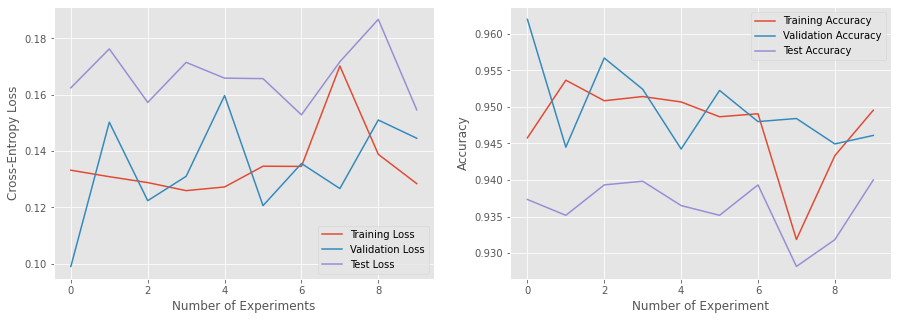

In [13]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(exp_losses_train, label='Training Loss')
plt.plot(exp_losses_val, label='Validation Loss')
plt.plot(test_loss_exp, label='Test Loss')
plt.xlabel('Number of Experiments')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc_exp, label='Training Accuracy')
plt.plot(val_acc_exp, label='Validation Accuracy')
plt.plot(test_accuracy_exp, label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

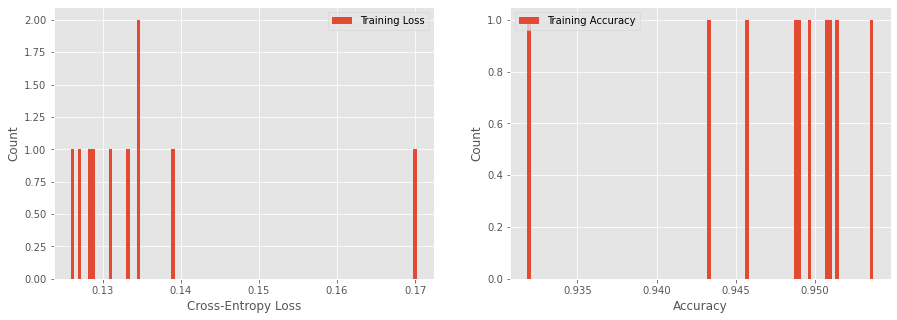

In [14]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.hist(exp_losses_train, label='Training Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(train_acc_exp, label='Training Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

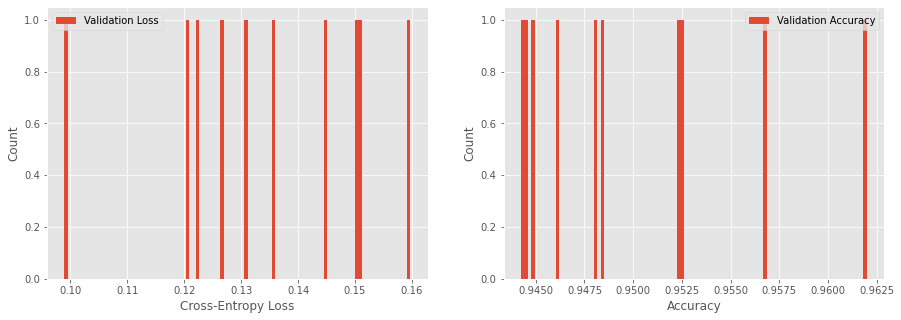

In [15]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(exp_losses_val, label='Validation Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(val_acc_exp, label='Validation Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

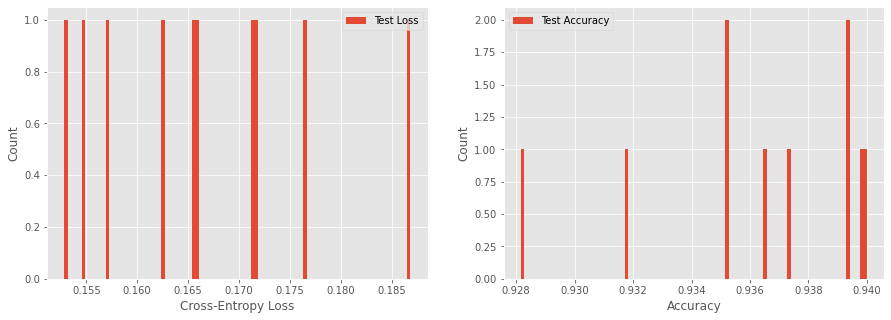

In [16]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.hist(test_loss_exp, label='Test Loss',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
plt.hist(test_accuracy_exp, label='Test Accuracy',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()

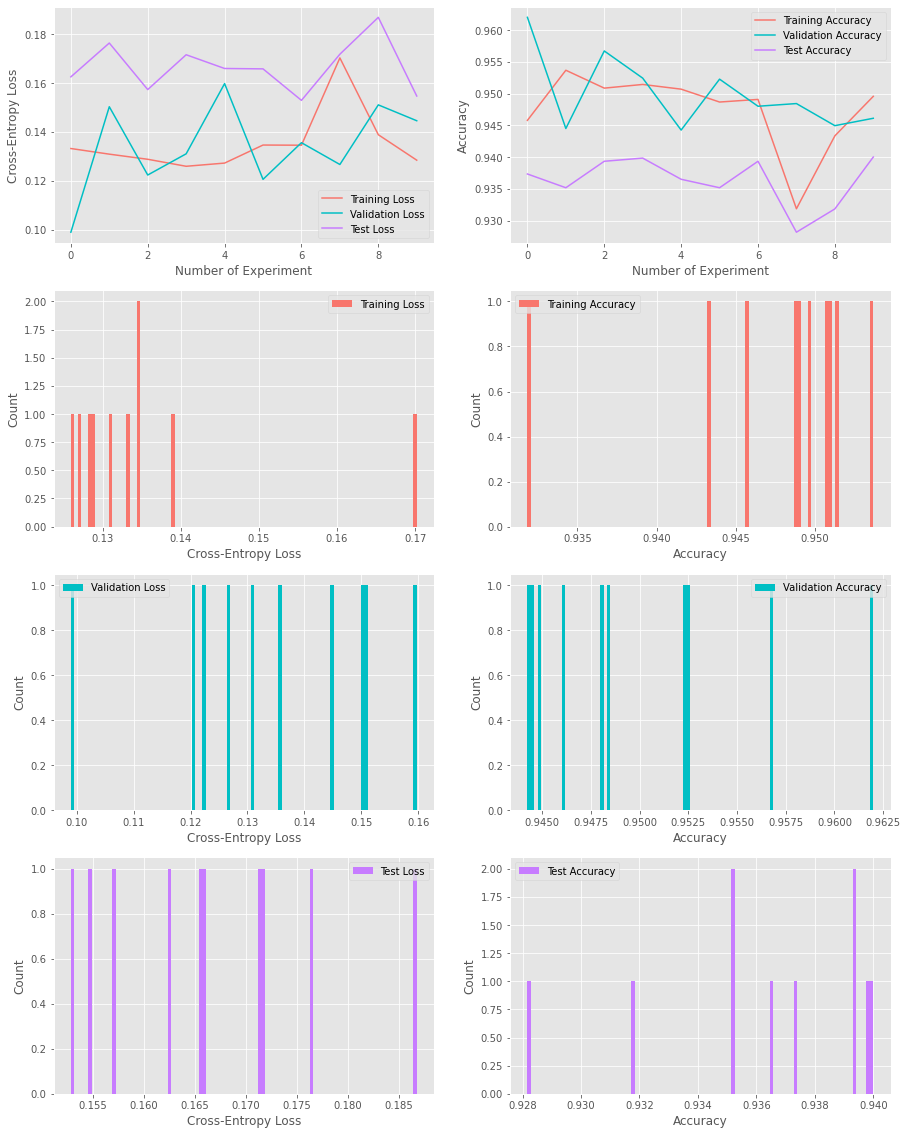

In [17]:
plt.subplots(figsize=(15,20))

plt.subplot(421)
plt.plot(exp_losses_train, label='Training Loss',color='#F8766D')
plt.plot(exp_losses_val, label='Validation Loss',color='#00BFC4')
plt.plot(test_loss_exp, label='Test Loss',color='#C77CFF')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(422)
plt.plot(train_acc_exp, label='Training Accuracy',color='#F8766D')
plt.plot(val_acc_exp, label='Validation Accuracy',color='#00BFC4')
plt.plot(test_accuracy_exp, label='Test Accuracy',color='#C77CFF')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(423)
plt.hist(exp_losses_train, label='Training Loss',color='#F8766D',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(424)
plt.hist(train_acc_exp, label='Training Accuracy',color='#F8766D',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(425)
plt.hist(exp_losses_val, label='Validation Loss',color='#00BFC4',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(426)
plt.hist(val_acc_exp, label='Validation Accuracy',color='#00BFC4',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.subplot(427)
plt.hist(test_loss_exp, label='Test Loss',color='#C77CFF',bins=100)
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Count')
plt.legend()

plt.subplot(428)
plt.hist(test_accuracy_exp, label='Test Accuracy',color='#C77CFF',bins=100)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.show()